In [ ]:
!pip install swig
!pip install box2d-py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 51.9 MB/s eta 0:00:00
  Using cached box2d-py-2.3.8.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.8-cp311-cp311-linux_x86_64.whl size=2379444 sha256=723d8412a9ec82adbebdb15a442cdd467d6a14629ead6a74bf022f028901486a
  Stored in directory: /root/.cache/pip/wheels/3f/95/02/4cb5adc9f6dcaeb9639c2271f630a66ab4440102414804c45c
Successfully built box2d-py


Observation space: Box(0, 255, (96, 96, 3), uint8)
Action space: Discrete(5)


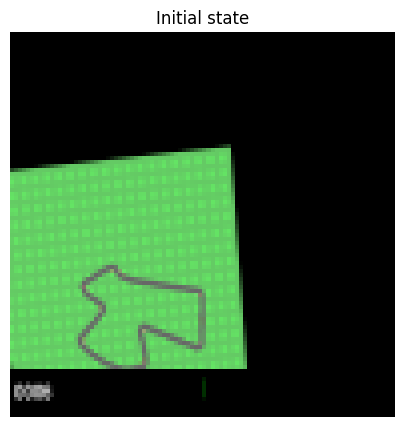

In [ ]:
# Import necessary libraries
import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

# Create the environment with discrete action space
env = gym.make("CarRacing-v3", continuous=False)

# Print environment details
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

# Check initial state
state, info = env.reset()
plt.figure(figsize=(5, 5))
plt.imshow(state)
plt.title("Initial state")
plt.axis('off')
plt.show()


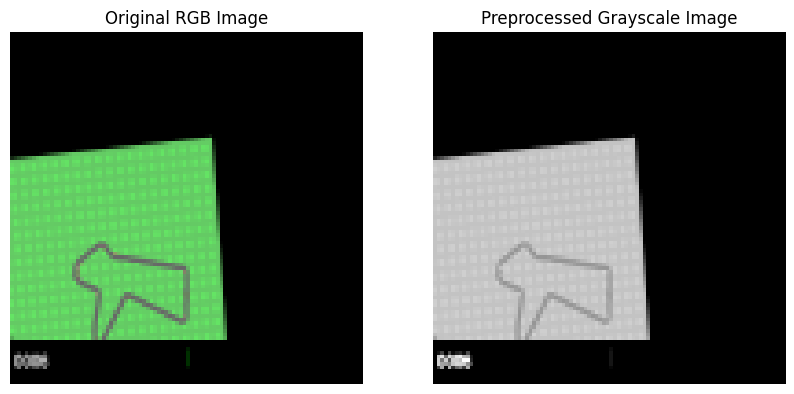

In [ ]:
def preprocess_observation(observation):
    """
    Preprocess the observation by converting to grayscale and normalizing.

    Args:
        observation: 96x96x3 RGB image

    Returns:
        Preprocessed observation (1x96x96)
    """
    # Convert RGB to grayscale
    gray = np.mean(observation, axis=2).astype(np.uint8)

    # Normalize pixel values to [0, 1]
    normalized = gray / 255.0

    # Reshape for the neural network (channel-first format)
    return normalized.reshape(1, 96, 96)

# Visualize preprocessing
state, _ = env.reset()
processed_state = preprocess_observation(state)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(state)
plt.title("Original RGB Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(processed_state[0], cmap='gray')
plt.title("Preprocessed Grayscale Image")
plt.axis('off')
plt.show()


In [ ]:
class DQN(nn.Module):
    """Deep Q-Network for processing image observations and predicting action values."""

    def __init__(self, input_shape, n_actions):
        """
        Initialize the network architecture.

        Args:
            input_shape: Shape of the input observation (channels, height, width)
            n_actions: Number of possible actions
        """
        super(DQN, self).__init__()

        # Convolutional layers
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        # Calculate the size of the output from the conv layers
        conv_out_size = self._get_conv_out(input_shape)

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def _get_conv_out(self, shape):
        """Calculate the output size of the convolutional layers."""
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        """Forward pass through the network."""
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)


In [ ]:
class ReplayBuffer:
    """Buffer to store and sample experiences for training."""

    def __init__(self, capacity):
        """
        Initialize buffer with fixed capacity.

        Args:
            capacity: Maximum number of experiences to store
        """
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        """Add an experience to the buffer."""
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        """Sample a random batch of experiences."""
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)

    def __len__(self):
        """Return the current size of the buffer."""
        return len(self.buffer)


In [ ]:
class DQNAgent:
    """DQN agent that learns to drive the car using deep reinforcement learning."""

    def __init__(self, state_dim, action_dim, learning_rate=0.0001, gamma=0.99,
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995,
                 buffer_capacity=10000, batch_size=64):
        """
        Initialize the DQN agent.

        Args:
            state_dim: Dimensions of the state space
            action_dim: Number of possible actions
            learning_rate: Learning rate for optimizer
            gamma: Discount factor for future rewards
            epsilon_start: Initial exploration rate
            epsilon_end: Final exploration rate
            epsilon_decay: Rate at which epsilon decays
            buffer_capacity: Size of replay buffer
            batch_size: Number of samples for learning
        """
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size

        # Initialize Q-networks
        self.policy_net = DQN(state_dim, action_dim)  # Main network for action selection
        self.target_net = DQN(state_dim, action_dim)  # Target network for stability
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        self.memory = ReplayBuffer(buffer_capacity)

        # Use GPU if available
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy_net.to(self.device)
        self.target_net.to(self.device)

        print(f"DQN Agent initialized. Using device: {self.device}")

    def select_action(self, state):
        """
        Select action using epsilon-greedy policy.

        Args:
            state: Current state observation

        Returns:
            Selected action
        """
        if random.random() < self.epsilon:
            # Exploration: choose random action
            return random.randrange(self.action_dim)
        else:
            # Exploitation: choose best action according to the model
            with torch.no_grad():
                state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
                q_values = self.policy_net(state)
                return q_values.max(1)[1].item()

    def learn(self):
        """Update the policy network using a batch of experiences."""
        if len(self.memory) < self.batch_size:
            return None

        # Sample a batch of experiences
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        # Convert to tensors and move to device
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        # Get current Q values
        current_q = self.policy_net(states).gather(1, actions.unsqueeze(1))

        # Get max Q values for next states from target model
        next_q = self.target_net(next_states).max(1)[0].detach()

        # Compute target Q values using Bellman equation
        target_q = rewards + (1 - dones) * self.gamma * next_q

        # Compute loss
        loss = F.smooth_l1_loss(current_q, target_q.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # Clip gradients to prevent exploding gradients
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

        # Update epsilon (reduce exploration over time)
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

        return loss.item()

    def update_target_network(self):
        """Update the target network with the policy network's weights."""
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def save(self, path):
        """Save the agent's state to a file."""
        torch.save({
            'policy_net_state_dict': self.policy_net.state_dict(),
            'target_net_state_dict': self.target_net.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'epsilon': self.epsilon
        }, path)
        print(f"Agent saved to {path}")

    def load(self, path):
        """Load the agent's state from a file."""
        checkpoint = torch.load(path)
        self.policy_net.load_state_dict(checkpoint['policy_net_state_dict'])
        self.target_net.load_state_dict(checkpoint['target_net_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.epsilon = checkpoint['epsilon']
        print(f"Agent loaded from {path}")


In [ ]:
def train_agent(env, agent, num_episodes=500, update_target_every=10,
                print_every=10, save_every=50, render=False):
    """
    Train the DQN agent.

    Args:
        env: Gym environment
        agent: DQN agent
        num_episodes: Number of episodes to train for
        update_target_every: Episodes between target network updates
        print_every: Episodes between printing stats
        save_every: Episodes between saving the agent
        render: Whether to render the environment during training

    Returns:
        List of episode rewards
    """
    rewards = []
    best_avg_reward = -float('inf')

    for episode in range(1, num_episodes + 1):
        state, _ = env.reset()
        state = preprocess_observation(state)

        episode_reward = 0
        done = False
        truncated = False
        steps = 0

        # Training loop for one episode
        while not (done or truncated):
            if render:
                env.render()

            # Select and perform an action
            action = agent.select_action(state)
            next_state, reward, done, truncated, _ = env.step(action)
            next_state = preprocess_observation(next_state)

            # Store the transition in memory
            agent.memory.add(state, action, reward, next_state, done)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization
            loss = agent.learn()

            episode_reward += reward
            steps += 1

            if done or truncated:
                break

        # Update the target network every few episodes
        if episode % update_target_every == 0:
            agent.update_target_network()
            print(f"Target network updated at episode {episode}")

        # Save the model every few episodes
        if episode % save_every == 0:
            agent.save(f"car_racing_dqn_episode_{episode}.pth")

        rewards.append(episode_reward)

        # Print statistics
        if episode % print_every == 0:
            avg_reward = np.mean(rewards[-print_every:])
            print(f"Episode {episode}/{num_episodes}, Avg Reward: {avg_reward:.2f}, "
                  f"Epsilon: {agent.epsilon:.4f}, Steps: {steps}")

            # Plot progress
            plot_training_progress(rewards)

            # Save best model
            if avg_reward > best_avg_reward:
                best_avg_reward = avg_reward
                agent.save("car_racing_dqn_best.pth")
                print(f"New best model saved with avg reward: {best_avg_reward:.2f}")

    return rewards

def plot_training_progress(rewards):
    """Plot the training progress."""
    plt.figure(figsize=(10, 5))
    plt.plot(rewards)
    plt.title('Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.grid(True)
    plt.show()


In [ ]:
def evaluate_agent(env, agent, num_episodes=10, render=True):
    """
    Evaluate a trained agent.

    Args:
        env: Gym environment
        agent: DQN agent
        num_episodes: Number of episodes to evaluate
        render: Whether to render the environment

    Returns:
        List of evaluation rewards
    """
    rewards = []

    for episode in range(1, num_episodes + 1):
        state, _ = env.reset()
        state = preprocess_observation(state)

        episode_reward = 0
        done = False
        truncated = False

        while not (done or truncated):
            if render:
                env.render()
                time.sleep(0.01)  # Slow down rendering for better visualization

            # Use greedy policy (no exploration)
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(agent.device)
                q_values = agent.policy_net(state_tensor)
                action = q_values.max(1)[1].item()

            next_state, reward, done, truncated, _ = env.step(action)
            next_state = preprocess_observation(next_state)

            state = next_state
            episode_reward += reward

            if done or truncated:
                break

        rewards.append(episode_reward)
        print(f"Evaluation Episode {episode}/{num_episodes}, Reward: {episode_reward:.2f}")

    avg_reward = np.mean(rewards)
    print(f"Average Evaluation Reward: {avg_reward:.2f}")

    return rewards


DQN Agent initialized. Using device: cpu
Starting training...
Target network updated at episode 2
Agent saved to car_racing_dqn_episode_2.pth
Episode 2/10, Avg Reward: -99.83, Epsilon: 0.0100, Steps: 1000


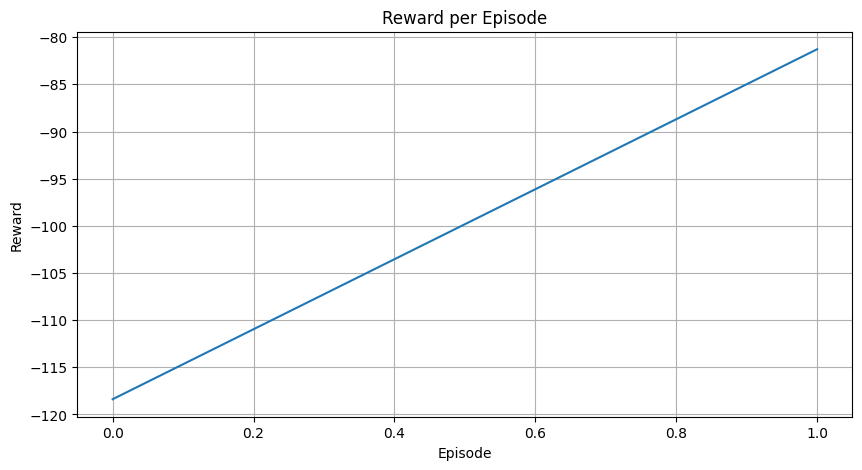

Agent saved to car_racing_dqn_best.pth
New best model saved with avg reward: -99.83
Target network updated at episode 4
Agent saved to car_racing_dqn_episode_4.pth
Episode 4/10, Avg Reward: -73.64, Epsilon: 0.0100, Steps: 1000


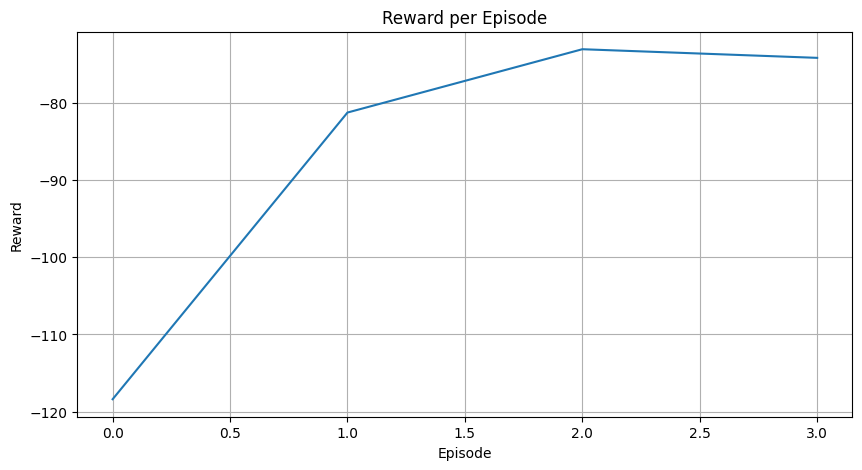

Agent saved to car_racing_dqn_best.pth
New best model saved with avg reward: -73.64
Target network updated at episode 6
Agent saved to car_racing_dqn_episode_6.pth
Episode 6/10, Avg Reward: -57.70, Epsilon: 0.0100, Steps: 1000


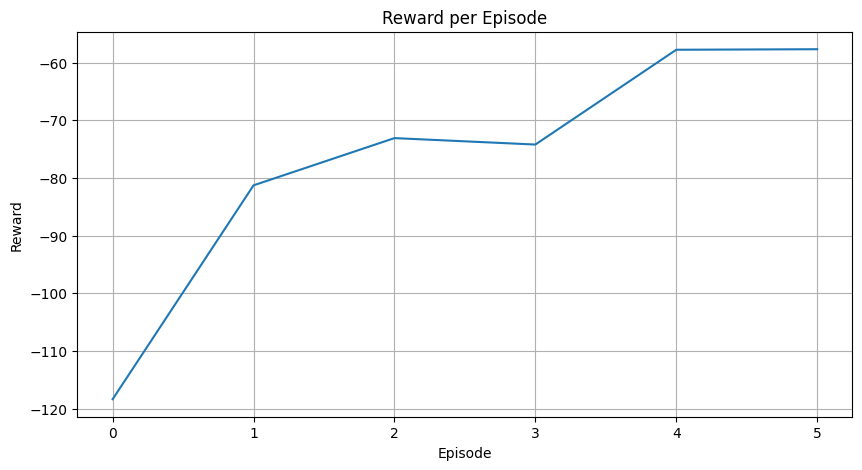

Agent saved to car_racing_dqn_best.pth
New best model saved with avg reward: -57.70
Target network updated at episode 8
Agent saved to car_racing_dqn_episode_8.pth
Episode 8/10, Avg Reward: -64.10, Epsilon: 0.0100, Steps: 1000


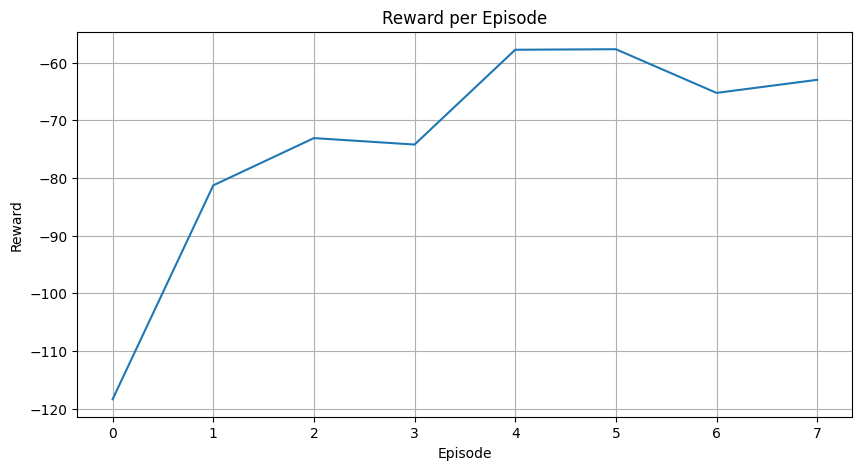

Target network updated at episode 10
Agent saved to car_racing_dqn_episode_10.pth
Episode 10/10, Avg Reward: -87.16, Epsilon: 0.0100, Steps: 1000


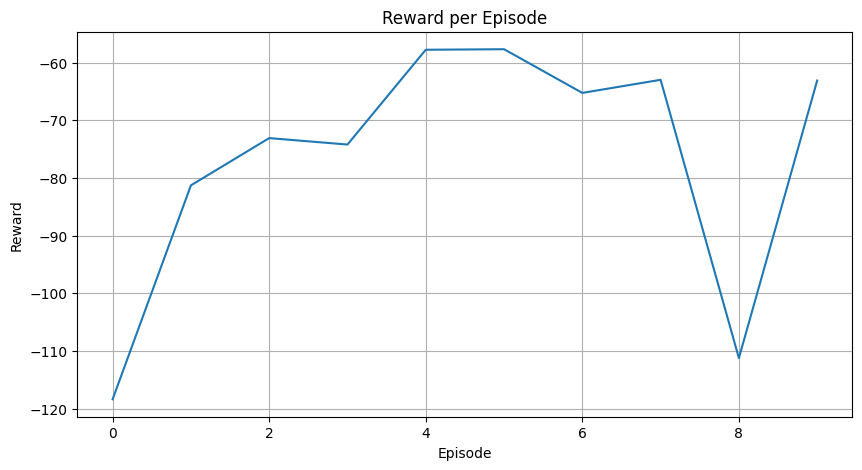

Agent saved to car_racing_dqn_final.pth
Starting evaluation...
Evaluation Episode 1/5, Reward: -89.90
Evaluation Episode 2/5, Reward: -89.09
Evaluation Episode 3/5, Reward: -90.57
Evaluation Episode 4/5, Reward: -84.85
Evaluation Episode 5/5, Reward: -90.07
Average Evaluation Reward: -88.89


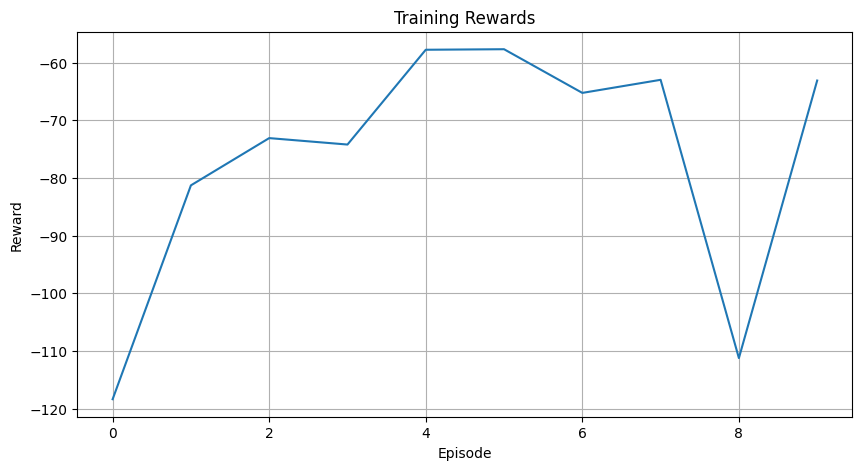

In [ ]:
def main():
    """Main function to train and evaluate the DQN agent."""
    # Set random seeds for reproducibility
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)

    # Create the environment
    env = gym.make("CarRacing-v3", continuous=False)

    # Define state and action dimensions
    state_dim = (1, 96, 96)  # After preprocessing (1 channel grayscale)
    action_dim = env.action_space.n  # 5 for discrete action space

    # Create the agent
    agent = DQNAgent(
        state_dim=state_dim,
        action_dim=action_dim,
        learning_rate=0.0001,
        gamma=0.99,
        epsilon_start=1.0,
        epsilon_end=0.01,
        epsilon_decay=0.995,
        buffer_capacity=50000,
        batch_size=32
    )

    # Train the agent
    print("Starting training...")
    train_rewards = train_agent(
        env=env,
        agent=agent,
        num_episodes=10,
        update_target_every=2,
        print_every=2,
        save_every=2,
        render=False
    )

    # Save the final agent
    agent.save("car_racing_dqn_final.pth")

    # Evaluate the agent
    print("Starting evaluation...")
    eval_rewards = evaluate_agent(
        env=env,
        agent=agent,
        num_episodes=5,
        render=True
    )

    # Close the environment
    env.close()

    # Final plot of training rewards
    plt.figure(figsize=(10, 5))
    plt.plot(train_rewards)
    plt.title('Training Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.grid(True)
    plt.savefig('car_racing_training_rewards.png')
    plt.show()

# Run the main function
if __name__ == "__main__":
    main()
